In [1]:
# import dependencies
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from zipfile import ZipFile
import json
import os.path
import re
import pickle

import data_download

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [2]:
# movies, links, ratings, tags = data_download.load_unprocessed_df(use_large=False)
movies, links, ratings, tags, genome_tags, genome_scores = data_download.load_unprocessed_df(use_large=True)

MovieLens 25M Dataset is downloaded!
MovieLens Latest Small Dataset is downloaded!
MovieLens 25M Dataset is already extracted!
MovieLens Latest Small Dataset is already extracted!


In [3]:
%%time
user_ids = ratings.userId.unique().tolist()
user2idx = {userId: idx for (idx, userId) in enumerate(user_ids)}
idx2user = {idx: userId for (idx, userId) in enumerate(user_ids)}
ratings.userId = ratings.userId.map(user2idx)

movie_ids = ratings.movieId.unique().tolist()
movie2idx = {movieId: idx for (idx, movieId) in enumerate(movie_ids)}
idx2movie = {idx: movieId for (idx, movieId) in enumerate(movie_ids)}
ratings.movieId = ratings.movieId.map(movie2idx)

# map rest
tags.movieId = tags.movieId.map(movie2idx)
movies.movieId = movies.movieId.map(movie2idx)
links.movieId = links.movieId.map(movie2idx)

CPU times: user 1.52 s, sys: 172 ms, total: 1.7 s
Wall time: 1.69 s


In [4]:
num_users = int(ratings.userId.nunique())
num_movies = int(ratings.movieId.nunique())
ratings["rating"] = ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 162541, Number of Movies: 59047, Min rating: 0.5, Max rating: 5.0


In [5]:
# drop some columns we do not care about
ratings = ratings.drop("timestamp", axis=1)
tags = tags.drop("timestamp", axis=1)

In [6]:
# drop duplicates for ratings for content 
ratings_content = ratings.drop_duplicates("movieId")

In [7]:
# basic stats
print("{} unique movies in ratings_content".format(len(ratings_content.movieId.unique())))
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

59047 unique movies in ratings_content
41876 unique movies in tags.csv
59048 unique movies in movies.csv


In [8]:
# we need take make sure that we have equal movies and ratings.
movies.isnull().sum()

movieId    3376
title         0
genres        0
dtype: int64

In [9]:
movies[~movies.movieId.isin(ratings_content.movieId)]

,movieId,title,genres
8371,nan,Break of Hearts (1935),Drama|Romance
8763,nan,Baby Blue Marine (1976),Drama
11556,nan,"Thousand and One Nights, A (1001 Nights) (1945)",Adventure
11997,nan,Suicide Killers (2006),Documentary
12173,nan,Alex in Wonder (Sex and a Girl) (2001),Comedy|Drama
...,...,...,...
62238,nan,Eternal Blood (2002),Action|Horror|Thriller
62239,nan,Big Business (1929),Comedy
62240,nan,The Student of Prague (1926),Horror
62298,nan,The Coldest Game (2019),(no genres listed)


In [10]:
movies = movies[movies['movieId'].notna()]

In [11]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [12]:
# basic stats
print("{} unique movies in ratings_content".format(len(ratings_content.movieId.unique())))
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

59047 unique movies in ratings_content
41876 unique movies in tags.csv
59047 unique movies in movies.csv


In [13]:
# do we have tags with movies that do NOT have a ratings?
len(tags[~tags["movieId"].isin(ratings_content.movieId)]["movieId"].unique())

array([nan])

In [17]:
# movies that are not in ratings, should be removed (using right join)
tags_content = pd.merge(tags, ratings_content, on="movieId", how="right")

In [18]:
tags_content[tags_content.movieId == 0]

,userId_x,movieId,tag,userId_y,rating
0,264.000,0.000,assassin,0,5.000
1,264.000,0.000,Black comedy,0,5.000
2,264.000,0.000,cult film,0,5.000
3,264.000,0.000,dark comedy,0,5.000
4,264.000,0.000,Quentin Tarantino,0,5.000
...,...,...,...,...,...
4762,162400.000,0.000,Oscar Nominee: Best Picture,0,5.000
4763,162400.000,0.000,Quentin Tarantino,0,5.000
4764,162400.000,0.000,satire,0,5.000
4765,162400.000,0.000,Steve Buscemi,0,5.000


In [19]:
tags_content.head()

,userId_x,movieId,tag,userId_y,rating
0,264.000,0.000,assassin,0,5.000
1,264.000,0.000,Black comedy,0,5.000
2,264.000,0.000,cult film,0,5.000
3,264.000,0.000,dark comedy,0,5.000
4,264.000,0.000,Quentin Tarantino,0,5.000


In [20]:
len(tags[~tags["movieId"].isin(ratings_content.movieId)]["movieId"].unique())

1

In [21]:
# after some clean
print("{} unique movies in ratings_content".format(len(ratings_content.movieId.unique())))
print("{} unique movies in tags_content".format(len(tags_content.movieId.unique())))
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

59047 unique movies in ratings_content
59047 unique movies in tags_content
59047 unique movies in movies.csv


In [22]:
# handle genres (remove all non alphabet characters)
movies['genres'] = movies['genres'].str.replace(pat="|", repl=" ")
movies['genres'] = movies['genres'].str.replace(pat="-", repl="")
movies['genres'] = movies['genres'].str.replace(pat="(no genres listed)", repl="")
movies['genres'] = movies['genres'].str.replace(pat="(", repl="")
movies['genres'] = movies['genres'].str.replace(pat=")", repl="")
movies.head()

,movieId,title,genres
0,70.000,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,1103.000,Jumanji (1995),Adventure Children Fantasy
2,1017.000,Grumpier Old Men (1995),Comedy Romance
3,4270.000,Waiting to Exhale (1995),Comedy Drama Romance
4,1858.000,Father of the Bride Part II (1995),Comedy


In [23]:
# after some clean
print("{} unique movies in ratings_content".format(len(ratings_content.movieId.unique())))
print("{} unique movies in tags_content".format(len(tags_content.movieId.unique())))
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

59047 unique movies in ratings_content
59047 unique movies in tags_content
59047 unique movies in movies.csv


In [24]:
# merge movies with ratings and map idx
movies_content = pd.merge(movies, ratings_content, on="movieId", how="inner")

In [25]:
# after some clean
print("{} unique movies in ratings_content".format(len(ratings_content.movieId.unique())))
print("{} unique movies in tags_content".format(len(tags_content.movieId.unique())))
print("{} unique movies in movies_content".format(len(movies_content.movieId.unique())))

59047 unique movies in ratings_content
59047 unique movies in tags_content
59047 unique movies in movies_content


In [26]:
movies.query("title == 'Batman Begins (2005)'")

,movieId,title,genres
10002,245.000,Batman Begins (2005),Action Crime IMAX


In [27]:
# there is some nans in tags
tags_content.isnull().sum().sort_values(ascending = False)

tag         17188
userId_x    17172
rating          0
userId_y        0
movieId         0
dtype: int64

In [28]:
# fill some nans 
tags_content.fillna("", inplace=True)

In [29]:
tags_content.isnull().sum().sort_values(ascending = False)

rating      0
userId_y    0
tag         0
movieId     0
userId_x    0
dtype: int64

In [30]:
tags_content.head()

,userId_x,movieId,tag,userId_y,rating
0,264.000,0.000,assassin,0,5.000
1,264.000,0.000,Black comedy,0,5.000
2,264.000,0.000,cult film,0,5.000
3,264.000,0.000,dark comedy,0,5.000
4,264.000,0.000,Quentin Tarantino,0,5.000


In [31]:
tags_content = pd.DataFrame(tags_content.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
tags_content.reset_index(inplace=True)

In [32]:
tags_content.head()

,movieId,tag
0,0.000,assassin Black comedy cult film dark comedy Qu...
1,1.000,atmospheric enigmatic gentle lyrical meditativ...
2,2.000,atmospheric CRISIS OF FAITH DEATH OF A CHILD D...
3,3.000,biting cerebral cynical harsh irreverent madca...
4,4.000,Dance 50s imdb top 250 musical romance happy m...


In [33]:
movies_content.head()

,movieId,title,genres,userId,rating
0,70.000,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,3.500
1,1103.000,Jumanji (1995),Adventure Children Fantasy,8,5.000
2,1017.000,Grumpier Old Men (1995),Comedy Romance,7,4.000
3,4270.000,Waiting to Exhale (1995),Comedy Drama Romance,140,3.000
4,1858.000,Father of the Bride Part II (1995),Comedy,17,4.000


In [34]:
# group tags by movie id to create corpus
content_data = pd.merge(movies_content, tags_content, on="movieId", how="right")
content_data["corpus"] = content_data[["genres", "tag"]].apply(lambda x: " ".join(x), axis=1)

In [35]:
content_data.head()

,movieId,title,genres,userId,rating,tag,corpus
0,0.000,Pulp Fiction (1994),Comedy Crime Drama Thriller,0,5.000,assassin Black comedy cult film dark comedy Qu...,Comedy Crime Drama Thriller assassin Black com...
1,1.000,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,0,3.500,atmospheric enigmatic gentle lyrical meditativ...,Drama atmospheric enigmatic gentle lyrical med...
2,2.000,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,0,5.000,atmospheric CRISIS OF FAITH DEATH OF A CHILD D...,Drama atmospheric CRISIS OF FAITH DEATH OF A C...
3,3.000,Underground (1995),Comedy Drama War,0,5.000,biting cerebral cynical harsh irreverent madca...,Comedy Drama War biting cerebral cynical harsh...
4,4.000,Singin' in the Rain (1952),Comedy Musical Romance,0,3.500,Dance 50s imdb top 250 musical romance happy m...,Comedy Musical Romance Dance 50s imdb top 250 ...


In [36]:
movies_content[movies_content.movieId == 245]

,movieId,title,genres,userId,rating
10000,245.000,Batman Begins (2005),Action Crime IMAX,1,5.000


In [37]:
content_data[content_data.movieId == 245]

,movieId,title,genres,userId,rating,tag,corpus
245,245.000,Batman Begins (2005),Action Crime IMAX,1,5.000,action batman billionaire Christian Bale comic...,Action Crime IMAX action batman billionaire Ch...


In [38]:
# drop items we do not need 
content_data = content_data.drop("rating", axis=1)
content_data = content_data.drop("userId", axis=1)

In [39]:
content_data.head()

,movieId,title,genres,tag,corpus
0,0.000,Pulp Fiction (1994),Comedy Crime Drama Thriller,assassin Black comedy cult film dark comedy Qu...,Comedy Crime Drama Thriller assassin Black com...
1,1.000,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,atmospheric enigmatic gentle lyrical meditativ...,Drama atmospheric enigmatic gentle lyrical med...
2,2.000,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,atmospheric CRISIS OF FAITH DEATH OF A CHILD D...,Drama atmospheric CRISIS OF FAITH DEATH OF A C...
3,3.000,Underground (1995),Comedy Drama War,biting cerebral cynical harsh irreverent madca...,Comedy Drama War biting cerebral cynical harsh...
4,4.000,Singin' in the Rain (1952),Comedy Musical Romance,Dance 50s imdb top 250 musical romance happy m...,Comedy Musical Romance Dance 50s imdb top 250 ...


In [40]:
# find ratings count and mean
movie_summary = pd.DataFrame(ratings.groupby('movieId')['rating'].mean())
movie_summary['ratings_count'] = ratings.groupby('movieId')['rating'].count()
movie_summary.head()

,rating,ratings_count
movieId,,
0,4.189,79672
1,4.073,7058
2,3.981,6616
3,3.946,1269
4,4.051,10895


In [41]:
# merge with content data
content_data = pd.merge(content_data, movie_summary, on="movieId", how="left")
content_data.head()

,movieId,title,genres,tag,corpus,rating,ratings_count
0,0.000,Pulp Fiction (1994),Comedy Crime Drama Thriller,assassin Black comedy cult film dark comedy Qu...,Comedy Crime Drama Thriller assassin Black com...,4.189,79672
1,1.000,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,atmospheric enigmatic gentle lyrical meditativ...,Drama atmospheric enigmatic gentle lyrical med...,4.073,7058
2,2.000,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,atmospheric CRISIS OF FAITH DEATH OF A CHILD D...,Drama atmospheric CRISIS OF FAITH DEATH OF A C...,3.981,6616
3,3.000,Underground (1995),Comedy Drama War,biting cerebral cynical harsh irreverent madca...,Comedy Drama War biting cerebral cynical harsh...,3.946,1269
4,4.000,Singin' in the Rain (1952),Comedy Musical Romance,Dance 50s imdb top 250 musical romance happy m...,Comedy Musical Romance Dance 50s imdb top 250 ...,4.051,10895


In [42]:
content_data.shape

(59047, 7)

## Similarity Calculator

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

class SimilarityCalculator(object):
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.ids = embeddings.index.tolist()
        self.similarity_matrix = self.calculate_cosine_similarity_matrix()
        
    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        similarity_matrix = pd.DataFrame(
            cosine_similarity(X=self.embeddings),
            index=self.ids
        )
        similarity_matrix.columns = self.ids
        return similarity_matrix
    
    def predict_similar_items(self, seed_item, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_items = pd.DataFrame(self.similarity_matrix.loc[seed_item])
        similar_items.columns = ["similarity_score"]
        similar_items = similar_items.sort_values('similarity_score', ascending=False)
        similar_items = similar_items.head(n)
        similar_items.reset_index(inplace=True)
        similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
        return similar_items.to_dict()

In [44]:
def get_detailed_recs(movie_id, embeddings):
    #get similar movies
    sim_model = SimilarityCalculator(embeddings)
    output = sim_model.predict_similar_items(seed_item=movie_id, n=20)
    similar_movies = pd.DataFrame(output)
    similar_movies.set_index('item_id', inplace=True)
    sim_df = pd.merge(content_data, similar_movies, left_index=True, right_index=True)
    sim_df.sort_values('similarity_score', ascending=False, inplace=True)
    return sim_df.head(10)

In [163]:
def get_ensemble_recs(movie_id, content_embeddings, collaborative_embeddings):
    #get similar movies from content
    sim_model_cont = SimilarityCalculator(content_embeddings)
    cont_output = sim_model_cont.predict_similar_items(seed_item=movie_id, n=59047)
    similar_movies = pd.DataFrame(cont_output)
    similar_movies.set_index('item_id', inplace=True)
    sim_df_cont = pd.merge(content_data, similar_movies, left_index=True, right_index=True)
    sim_df_cont.sort_values('similarity_score', ascending=False, inplace=True)
    sim_df_cont = sim_df_cont.rename(index=str, columns={"similarity_score": "content_similarity_score"})

    #get similar movies from collaborative
    sim_model_coll = SimilarityCalculator(collaborative_embeddings)
    coll_output = sim_model_coll.predict_similar_items(seed_item=movie_id, n=59047)
    similar_movies = pd.DataFrame(coll_output)
    similar_movies.set_index('item_id', inplace=True)
    sim_df_coll = pd.merge(content_data, similar_movies, left_index=True, right_index=True)
    sim_df_coll.sort_values('similarity_score', ascending=False, inplace=True)
    sim_df_coll = sim_df_coll.rename(index=str, columns={"similarity_score": "collaborative_similarity_score"})

    #ensemble results
    sim_df_avg = pd.merge(sim_df_coll, pd.DataFrame(sim_df_cont['content_similarity_score']), left_index=True, right_index=True)
    sim_df_avg = sim_df_avg[sim_df_avg["ratings_count"] > 50]
    sim_df_avg['average_similarity_score'] = (sim_df_avg['content_similarity_score'] + sim_df_avg['collaborative_similarity_score'])/2
    sim_df_avg.sort_values('average_similarity_score', ascending=False, inplace=True)
    
    return sim_df_avg.head(10)

## Begin vectorization for Autoencoder

In [45]:
# run TF-IDF vectorizer
tf_idf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    min_df=0.0001,
    stop_words='english')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(content_data['corpus'])
tfidf_df = pd.DataFrame(tf_idf_matrix.toarray(), index=content_data.index.tolist())
print(tfidf_df.shape)
tfidf_df.head()

(59047, 10146)


,0,1,2,3,4,5,6,7,8,9,...,10136,10137,10138,10139,10140,10141,10142,10143,10144,10145
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.054,0.000,0.000,0.000,0.056,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### NN methods

In [46]:
def plot_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

In [47]:
def save_autoencoder_embeddings(i, encoded):
    with open('./data/autoencoder_embeddings_{}.pkl'.format(i), 'wb') as fh:
        pickle.dump(encoded, fh)

In [48]:
def save_collab_nn_embeddings(i, encoded):
    with open('./data/collab_nn_embeddings_{}.pkl'.format(i), 'wb') as fh:
        pickle.dump(encoded, fh)

### Autoencoder model

In [49]:
encoding_dim = 200
interput_dim = 5000

def build_autoencoder_model(data):
    input_size = data.shape[1]
    movie_input = keras.Input(shape=input_size, name="input")
    
    encoded = layers.Dense(interput_dim, activation='relu', name="Relu-Encoder-1")(movie_input)
    encoded = layers.BatchNormalization(name="BatchNorm-Encoder-1")(encoded)
    encoded = layers.Dropout(0.2, name="Dropout-Encoder-1")(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu', name="Relu-Encoder-2")(encoded)
    encoded = layers.BatchNormalization(name="BatchNorm-Encoder-2")(encoded)
    encoded = layers.Dropout(0.2, name="Dropout-Encoder-2")(encoded)

    decoded = layers.Dense(encoding_dim, activation='relu', name="Relu-Decoder-1")(encoded)
    decoded = layers.BatchNormalization(name="BatchNorm-Decoder-1")(decoded)
    decoded = layers.Dropout(0.2, name="Dropout-Decoder-1")(decoded)
    decoded = layers.Dense(interput_dim, activation='relu', name="Relu-Decoder-2")(decoded)
    decoded = layers.BatchNormalization(name="BatchNorm-Decoder-2")(decoded)
    decoded = layers.Dropout(0.2, name="Dropout-Decoder-2")(decoded)
    decoded = layers.Dense(input_size, name="output")(decoded)

    autoencoder = keras.Model(movie_input, decoded)
    autoencoder.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer=keras.optimizers.Adam(lr=0.001),
    )
    encoder_model = keras.Model(movie_input, encoded)
    
    return autoencoder, encoder_model

In [50]:
autoencoder, encoder_model = build_autoencoder_model(tfidf_df)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10146)]           0         
_________________________________________________________________
Relu-Encoder-1 (Dense)       (None, 5000)              50735000  
_________________________________________________________________
BatchNorm-Encoder-1 (BatchNo (None, 5000)              20000     
_________________________________________________________________
Dropout-Encoder-1 (Dropout)  (None, 5000)              0         
_________________________________________________________________
Relu-Encoder-2 (Dense)       (None, 200)               1000200   
_________________________________________________________________
BatchNorm-Encoder-2 (BatchNo (None, 200)               800       
_________________________________________________________________
Dropout-Encoder-2 (Dropout)  (None, 200)               0     

In [51]:
x_train = tfidf_df.to_numpy()
train_indices = int(0.8 * tfidf_df.shape[0])
x_train, x_val = (
    x_train[:train_indices],
    x_train[train_indices:],
)

In [52]:
x_train.shape

(47237, 10146)

In [53]:
x_val.shape

(11810, 10146)

In [54]:
def train_model(model, x_train, x_val):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='/ckpt/autoencoder-1/',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,
        patience=3, 
        min_lr=0.0001
    )

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    callbacks = [
        reduce_lr,
        early_stop,
        model_checkpoint_callback
    ]
    
    history = model.fit(
        x_train, 
        x_train,
        batch_size=64,
        epochs=10,
        verbose=1,
        callbacks=callbacks,
        validation_data=(x_val, x_val)
    )
    
    return history

In [55]:
history = train_model(autoencoder, x_train, x_val)

Train on 47237 samples, validate on 11810 samples
Epoch 1/10
47237/47237 [==============================] - 25s 521us/sample - loss: 0.1368 - val_loss: 0.0240
Epoch 2/10
47237/47237 [==============================] - 25s 535us/sample - loss: 0.0185 - val_loss: 0.0083
Epoch 3/10
47237/47237 [==============================] - 25s 534us/sample - loss: 0.0042 - val_loss: 0.0023
Epoch 4/10
47237/47237 [==============================] - 25s 532us/sample - loss: 0.0013 - val_loss: 0.0012
Epoch 5/10
47237/47237 [==============================] - 25s 534us/sample - loss: 6.0728e-04 - val_loss: 9.5671e-04
Epoch 6/10
47237/47237 [==============================] - 21s 448us/sample - loss: 7.4631e-04 - val_loss: 0.0026
Epoch 7/10
47237/47237 [==============================] - 21s 449us/sample - loss: 0.0013 - val_loss: 0.0019
Epoch 8/10
47237/47237 [==============================] - 25s 534us/sample - loss: 4.8577e-04 - val_loss: 4.9120e-04
Epoch 9/10
47237/47237 [==============================] - 

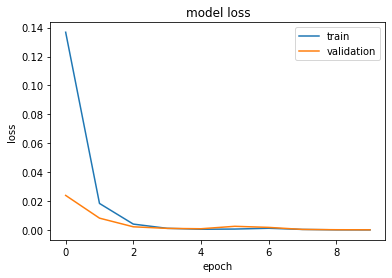

In [56]:
plot_history(history)

In [57]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10146)]           0         
_________________________________________________________________
Relu-Encoder-1 (Dense)       (None, 5000)              50735000  
_________________________________________________________________
BatchNorm-Encoder-1 (BatchNo (None, 5000)              20000     
_________________________________________________________________
Dropout-Encoder-1 (Dropout)  (None, 5000)              0         
_________________________________________________________________
Relu-Encoder-2 (Dense)       (None, 200)               1000200   
_________________________________________________________________
BatchNorm-Encoder-2 (BatchNo (None, 200)               800       
_________________________________________________________________
Dropout-Encoder-2 (Dropout)  (None, 200)               0   

In [58]:
autoencoder_embedding = encoder_model.predict(tfidf_df.to_numpy())
autoencoder_embedding.shape

(59047, 200)

In [59]:
autoencoder_embedding = pd.DataFrame(autoencoder_embedding)
autoencoder_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.475,0.925,-0.379,5.966,0.821,-0.539,-0.497,-0.435,-0.417,0.285,...,-0.315,-0.251,-0.394,-0.562,1.853,7.514,-0.345,-0.302,-0.389,-0.567
1,-0.475,-0.378,-0.379,-0.218,-0.159,-0.539,-0.497,-0.435,-0.417,-0.368,...,-0.315,-0.251,-0.394,-0.562,-0.142,-0.221,-0.345,-0.302,-0.389,0.717
2,-0.185,-0.378,-0.379,0.859,-0.159,-0.539,-0.497,-0.435,-0.417,0.096,...,-0.315,-0.251,-0.394,-0.195,-0.142,0.641,-0.225,-0.302,-0.389,-0.540
3,-0.475,-0.378,-0.379,-0.442,-0.159,-0.539,-0.497,-0.435,-0.417,-0.368,...,-0.315,-0.251,-0.394,0.402,-0.142,-0.221,-0.345,-0.302,-0.389,-0.567
4,-0.092,-0.157,-0.269,-0.442,-0.159,-0.539,-0.396,-0.435,-0.417,-0.368,...,-0.315,-0.251,-0.394,-0.454,-0.142,-0.221,-0.144,-0.302,-0.389,-0.499


In [60]:
get_detailed_recs(245, autoencoder_embedding)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
245,245.000,Batman Begins (2005),Action Crime IMAX,action batman billionaire Christian Bale comic...,Action Crime IMAX action batman billionaire Ch...,3.930,30684,1.000
161,161.000,Superman (1978),Action Adventure SciFi,sucks humorous light rousing slick tense upbea...,Action Adventure SciFi sucks humorous light ro...,3.396,14746,0.928
1699,1699.000,Batman Returns (1992),Action Crime,bird cage christmas holiday christmas tree cor...,Action Crime bird cage christmas holiday chris...,3.130,13401,0.923
967,967.000,Batman (1989),Action Crime Thriller,DC Comics superhero dark hero atmospheric blea...,Action Crime Thriller DC Comics superhero dark...,3.407,44110,0.919
3153,3153.000,Spawn (1997),Action Adventure SciFi Thriller,anti hero based on comic burn victim fistfight...,Action Adventure SciFi Thriller anti hero base...,2.637,5351,0.914
3690,3690.000,Frankenweenie (2012),Animation Comedy Horror IMAX,boy and his dog death animal death animal love...,Animation Comedy Horror IMAX boy and his dog d...,3.279,890,0.912
1535,1535.000,Pee-wee's Big Adventure (1985),Adventure Comedy,dark comedy dark humor heroes journey paul rub...,Adventure Comedy dark comedy dark humor heroes...,3.284,5583,0.887
162,162.000,Superman IV: The Quest for Peace (1987),Action Adventure SciFi,DC Comics superhero alter ego catholic school ...,Action Adventure SciFi DC Comics superhero alt...,2.011,3192,0.871
1700,1700.000,Batman & Robin (1997),Action Adventure Fantasy Thriller,DC Comics superhero credit card crime fighter ...,Action Adventure Fantasy Thriller DC Comics su...,2.160,9872,0.868
2548,2548.000,Batman: Mask of the Phantasm (1993),Animation Children,based on comic dc comics super power Batman su...,Animation Children based on comic dc comics su...,3.506,1843,0.867


In [61]:
content_data.query("title == 'Lord of the Rings: The Two Towers, The (2002)'")

,movieId,title,genres,tag,corpus,rating,ratings_count
36,36.000,"Lord of the Rings: The Two Towers, The (2002)",Adventure Fantasy,morality Owned imdb top 250 Adventure based on...,Adventure Fantasy morality Owned imdb top 250 ...,4.068,51138


In [62]:
get_detailed_recs(36, autoencoder_embedding)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
36,36.000,"Lord of the Rings: The Two Towers, The (2002)",Adventure Fantasy,morality Owned imdb top 250 Adventure based on...,Adventure Fantasy morality Owned imdb top 250 ...,4.068,51138,1.000
202,202.000,"Lord of the Rings: The Fellowship of the Ring,...",Adventure Fantasy,tolkien Adventure high fantasy music tolkien w...,Adventure Fantasy tolkien Adventure high fanta...,4.091,55736,0.995
749,749.000,"Hobbit: The Desolation of Smaug, The (2013)",Adventure Fantasy IMAX,adventure Tolkien adventure adventure hobbit b...,Adventure Fantasy IMAX adventure Tolkien adven...,3.630,8245,0.983
227,227.000,"Lord of the Rings: The Return of the King, The...",Action Adventure Drama Fantasy,Owned imdb top 250 Adventure epic adventure hi...,Action Adventure Drama Fantasy Owned imdb top ...,4.090,50797,0.979
745,745.000,Ender's Game (2013),Action Adventure SciFi IMAX,Harrison Ford True to the book aliens children...,Action Adventure SciFi IMAX Harrison Ford True...,3.399,3752,0.979
5607,5607.000,Noah (2014),Adventure Drama IMAX,3d apocalyptic based on bible bible god noah w...,Adventure Drama IMAX 3d apocalyptic based on b...,2.753,1372,0.978
4081,4081.000,Great Expectations (1998),Drama Romance,based on a book Bisexuality Great soundtrack H...,Drama Romance based on a book Bisexuality Grea...,3.252,2819,0.977
8279,8279.000,Percy Jackson: Sea of Monsters (2013),Adventure Children Fantasy,bad book adaptation Greek mythology adventure ...,Adventure Children Fantasy bad book adaptation...,2.967,778,0.977
1378,1378.000,Armageddon (1998),Action Romance SciFi Thriller,flashy humorous ominous rousing slick stylized...,Action Romance SciFi Thriller flashy humorous ...,2.993,22671,0.976
16976,16976.000,"Philosophers, The (After The Dark) (2013)",Drama Fantasy SciFi,visually appealing weak ending apocalypse phil...,Drama Fantasy SciFi visually appealing weak en...,3.245,153,0.976


In [63]:
content_data.query("title == 'Matrix, The (1999)'")

,movieId,title,genres,tag,corpus,rating,ratings_count
159,159.000,"Matrix, The (1999)",Action SciFi Thriller,alternate reality artificial intelligence cybe...,Action SciFi Thriller alternate reality artifi...,4.154,72674


In [64]:
get_detailed_recs(159, autoencoder_embedding)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
159,159.000,"Matrix, The (1999)",Action SciFi Thriller,alternate reality artificial intelligence cybe...,Action SciFi Thriller alternate reality artifi...,4.154,72674,1.000
440,440.000,"Matrix Revolutions, The (2003)",Action Adventure SciFi Thriller IMAX,Philosophical sequel future artificial intelli...,Action Adventure SciFi Thriller IMAX Philosoph...,3.210,18074,0.998
536,536.000,Children of Men (2006),Action Adventure Drama SciFi Thriller,imdb top 250 dystopia long shots Nudity (Tople...,Action Adventure Drama SciFi Thriller imdb top...,3.898,15063,0.998
284,284.000,Dark City (1998),Adventure FilmNoir SciFi Thriller,Neo-noir surreal aliens big brother dark dysto...,Adventure FilmNoir SciFi Thriller Neo-noir sur...,3.806,12170,0.998
418,418.000,"Matrix Reloaded, The (2003)",Action Adventure SciFi Thriller IMAX,virtual reality artificial intelligence martia...,Action Adventure SciFi Thriller IMAX virtual r...,3.347,23064,0.998
9324,9324.000,Alita: Battle Angel (2019),Action Romance SciFi Thriller,based on a manga post-apocalyptic uncanny vall...,Action Romance SciFi Thriller based on a manga...,3.611,622,0.998
618,618.000,Terminator Salvation (2009),Action Adventure SciFi Thriller,Anton Yelchin arnold cgi Christian Bale action...,Action Adventure SciFi Thriller Anton Yelchin ...,3.100,4385,0.996
789,789.000,Mad Max: Fury Road (2015),Action Adventure SciFi Thriller,Intense interesting revenge as motive sci-fi a...,Action Adventure SciFi Thriller Intense intere...,3.855,13479,0.996
778,778.000,Autómata (Automata) (2014),SciFi Thriller,artificial intelligence atmospheric desert dys...,SciFi Thriller artificial intelligence atmosph...,3.336,761,0.996
630,630.000,9 (2009),Adventure Animation SciFi,dolls fear good versus evil man versus machine...,Adventure Animation SciFi dolls fear good vers...,3.459,3291,0.996


In [65]:
#save_autoencoder_embeddings(1, autoencoder_embedding)
#save_autoencoder_embeddings(2, autoencoder_embedding)
#save_autoencoder_embeddings(3, autoencoder_embedding)
save_autoencoder_embeddings(4, autoencoder_embedding)
# USE #4 WHEN LOADING!

## Collaborative NN 

In [66]:
latent_dim = 100

def build_collab_nn_model(num_movies, num_users):
    movie_input = keras.Input(shape=[1], name="movie-input")
    movie_embed = layers.Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
    movie_flatt = layers.Flatten(name='movie-flatten')(movie_embed)

    user_input = keras.Input(shape=[1], name='user-input')
    user_embed = layers.Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
    user_flatt = layers.Flatten(name='user-flatten')(user_embed)

    concat_layers = layers.Dot(axes=1, name='movie-user-concat')([movie_flatt, user_flatt])
    concat_dropou = layers.Dropout(0.2)(concat_layers)

    fully_1 = layers.Dense(256, name='fc-1', activation='relu')(concat_dropou)
    fully_1_dropout = layers.Dropout(0.2, name='fc-1-dropout')(fully_1)

    fully_2 = layers.Dense(128, name='fc-2', activation='relu')(fully_1_dropout)
    fully_2_dropout = layers.Dropout(0.2, name='fc-2-dropout')(fully_2)

    fully_3 = layers.Dense(1, name='fc-3')(fully_2_dropout)
    
    model = tf.keras.Model([user_input, movie_input], fully_3)
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer=keras.optimizers.Adam(lr=0.001),
    )
    
    return model, movie_embed

In [67]:
def build_trainset(ratings):
    x = ratings[["userId", "movieId"]].values
    # Normalize the targets between 0 and 1. Makes it easy to train.
    y = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    # Assuming training on 90% of the data and validating on 10%.
    train_indices = int(0.9 * ratings.shape[0])
    x_train, x_val, y_train, y_val = (
        x[:train_indices],
        x[train_indices:],
        y[:train_indices],
        y[train_indices:],
    )
    return x_train, x_val, y_train, y_val

In [68]:
print("Number of movies {}, number of users {}".format(num_movies, num_users))

Number of movies 59047, number of users 162541


In [69]:
collab_nn, movie_embedding = build_collab_nn_model(num_movies, num_users)
collab_nn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 100)       5904800     movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 100)       16254200    user-input[0][0]                 
____________________________________________________________________________________________

In [70]:
def train_model_collab(model, x_train, y_train, x_val, y_val):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='/ckpt/collab-nn-1/',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,
        patience=2, 
        min_lr=0.0001
    )

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    callbacks = [
        reduce_lr,
        early_stop,
        model_checkpoint_callback
    ]
    
    history = model.fit(
        x=[x_train[:, 0], x_train[:, 1]], 
        y=y_train,
        batch_size=512,
        epochs=10,
        verbose=1,
        callbacks=callbacks,
        validation_data=([x_val[:, 0], x_val[:, 1]], y_val)
    )
    
    return history

In [226]:
x_train, x_val, y_train, y_val = build_trainset(ratings)

In [ ]:
history = train_model_collab(collab_nn, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

Train on 22500085 samples, validate on 2500010 samples
Epoch 1/10
 5060096/22500085 [=====>........................] - ETA: 1:21:30 - loss: 0.0550

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7919104/22500085 [=========>....................] - ETA: 1:08:09 - loss: 0.0540

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10205696/22500085 [============>.................] - ETA: 57:29 - loss: 0.0534

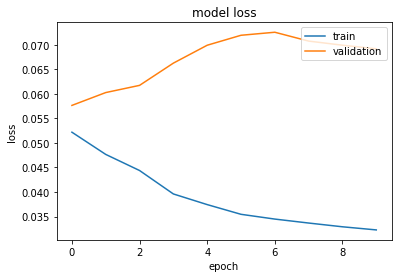

In [77]:
plot_history(history)

In [78]:
movie_layer = collab_nn.get_layer('movie-embedding')
movie_weights = movie_layer.get_weights()[0]
movie_weights.shape

(59048, 100)

In [79]:
movie_weights = pd.DataFrame(movie_weights)
movie_weights.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.001,0.214,0.006,0.046,0.026,-0.016,-0.155,-0.008,0.133,-0.102,...,-0.252,0.214,0.008,0.119,-0.047,0.162,-0.025,-0.139,0.050,-0.018
1,-0.036,0.133,-0.021,-0.129,0.100,0.113,-0.223,0.228,0.060,-0.072,...,-0.030,-0.183,-0.092,0.161,0.146,-0.070,0.208,0.041,-0.070,-0.245
2,0.042,0.084,-0.104,0.102,0.047,0.173,0.066,0.135,0.116,0.354,...,0.310,-0.057,-0.039,0.226,-0.039,0.133,-0.054,0.185,0.217,0.041
3,0.194,-0.088,0.187,0.021,-0.055,-0.133,0.017,-0.254,0.134,-0.293,...,-0.248,0.035,-0.081,-0.004,-0.024,0.013,0.099,-0.289,0.157,0.047
4,0.144,0.107,-0.040,0.170,0.242,-0.164,0.024,0.034,0.067,0.052,...,0.094,-0.005,-0.370,0.223,0.156,0.126,-0.052,0.098,0.115,0.045


In [80]:
save_collab_nn_embeddings(1, movie_weights)

In [81]:
get_detailed_recs(245, movie_weights)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
245,245.000,Batman Begins (2005),Action Crime IMAX,action batman billionaire Christian Bale comic...,Action Crime IMAX action batman billionaire Ch...,3.930,30684,1.000
27102,27102.000,Story of One Crime (1962),Animation,animation crime criminal short Soyuzmultfilm U...,Animation animation crime criminal short Soyuz...,2.667,6,0.423
41215,41215.000,Losing It (2006),Drama,,Drama,3.000,1,0.366
29665,29665.000,Seinto Seiya: Legend of Sanctuary (Seinto Seiy...,Animation,anime,Animation anime,2.188,16,0.362
47043,47043.000,Vada Chennai (2018),Action Crime,,Action Crime,3.250,4,0.359
5770,5770.000,Aberdeen (2000),Drama,alcohol cocaine daughter independent film lawy...,Drama alcohol cocaine daughter independent fil...,3.504,134,0.357
23952,23952.000,Game of Thrones: The Last Watch (2019),Documentary,,Documentary,3.412,17,0.357
45578,45578.000,Savage Planet (2007),SciFi,,SciFi,2.000,2,0.351
57607,57607.000,In Harihar Nagar (1990),Comedy Thriller,friends malayalam,Comedy Thriller friends malayalam,0.500,1,0.351
18528,18528.000,Vaastav: The Reality (1999),Crime Drama Thriller,mumbai underworld,Crime Drama Thriller mumbai underworld,3.700,10,0.350


In [82]:
get_detailed_recs(36, movie_weights)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
36,36.000,"Lord of the Rings: The Two Towers, The (2002)",Adventure Fantasy,morality Owned imdb top 250 Adventure based on...,Adventure Fantasy morality Owned imdb top 250 ...,4.068,51138,1.000
202,202.000,"Lord of the Rings: The Fellowship of the Ring,...",Adventure Fantasy,tolkien Adventure high fantasy music tolkien w...,Adventure Fantasy tolkien Adventure high fanta...,4.091,55736,0.384
3032,3032.000,The Last Witch Hunter (2015),Action Adventure Fantasy,new york uprising witch witch hunter blu-ray m...,Action Adventure Fantasy new york uprising wit...,3.178,628,0.370
16431,16431.000,Divine Intervention (Yadon ilaheyya) (2002),Comedy Drama Romance War,blindfold Elia Suleiman,Comedy Drama Romance War blindfold Elia Suleiman,3.165,82,0.368
33162,33162.000,And Then There Was You (2013),Drama,woman director,Drama woman director,4.000,1,0.362
40206,40206.000,Second Origin (2015),Drama SciFi,,Drama SciFi,3.500,1,0.361
7423,7423.000,"Welcome, or No Trespassing (1964)",Children Comedy,black and white comedy ussr Elem Klimov childr...,Children Comedy black and white comedy ussr El...,4.113,71,0.348
42664,42664.000,Monty Python: Parrot Sketch Not Included (1989),Comedy,monty python,Comedy monty python,3.833,6,0.347
59043,59043.000,Tough Luck (2004),Action Adventure Thriller,,Action Adventure Thriller,2.000,1,0.346
13456,13456.000,"Entertainer, The (1960)",Drama,british new wave dysfunctional family washed u...,Drama british new wave dysfunctional family wa...,3.758,130,0.346


In [83]:
get_detailed_recs(159, movie_weights)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
159,159.000,"Matrix, The (1999)",Action SciFi Thriller,alternate reality artificial intelligence cybe...,Action SciFi Thriller alternate reality artifi...,4.154,72674,1.000
23582,23582.000,"Woman of Affairs, A (1928)",Drama,alcoholic best friend childhood sweethearts ho...,Drama alcoholic best friend childhood sweethea...,3.667,6,0.389
2147,2147.000,Big Night (1996),Comedy Drama,1950s brothers failing business food italian k...,Comedy Drama 1950s brothers failing business f...,4.004,4844,0.369
2187,2187.000,Roger & Me (1989),Documentary,capitalism corporate greed economics unemploym...,Documentary capitalism corporate greed economi...,3.878,6898,0.362
19733,19733.000,Ryan's Daughter (1970),Drama Romance,atmospheric downbeat lavish sweeping tearjerki...,Drama Romance atmospheric downbeat lavish swee...,3.443,105,0.361
5683,5683.000,Black Dog (1998),Action Thriller,fbi truck Kevin Hooks,Action Thriller fbi truck Kevin Hooks,2.297,426,0.356
43548,43548.000,Election Day (2007),Documentary,woman director,Documentary woman director,3.500,4,0.349
22615,22615.000,The Exorcism of Molly Hartley (2015),Horror,exorcism atrocious writing bad writing bad wri...,Horror exorcism atrocious writing bad writing ...,1.804,28,0.338
9849,9849.000,Liquid Sky (1982),Comedy SciFi,alien androgyny bisexuality cocaine disco drug...,Comedy SciFi alien androgyny bisexuality cocai...,3.134,212,0.336
54044,54044.000,Wuthering High (2015),Drama Thriller,bleak high school indie love low budget pain t...,Drama Thriller bleak high school indie love lo...,1.750,2,0.321


In [90]:
get_ensemble_recs(245, autoencoder_embedding, movie_weights)

,movieId,title,genres,collaborative_similarity_score,content_similarity_score,average_similarity_score
245,942.000,Houseguest (1994),Comedy,1.000,1.000,1.000
43901,36700.000,Wonder Women (1973),Action Horror Thriller,0.284,0.803,0.543
8779,8780.000,High Anxiety (1977),Comedy Thriller,0.217,0.823,0.520
549,1289.000,True Romance (1993),Crime Thriller,0.255,0.773,0.514
43903,50401.000,Blacker than the Night (1975),Drama Fantasy Horror Thriller,0.158,0.811,0.484
54637,31046.000,Chronological Order (2010),SciFi,0.120,0.848,0.484
1699,27347.000,Mass Transit (1998),Comedy Drama,0.040,0.923,0.482
3153,4128.000,Malcolm X (1992),Drama,0.015,0.914,0.465
1535,4758.000,Air Bud (1997),Children Comedy,0.022,0.887,0.454
21874,47774.000,"Amsterdam Kill, The (1977)",Action Crime Drama,0.157,0.746,0.452


In [91]:
get_ensemble_recs(36, autoencoder_embedding, movie_weights)

,movieId,title,genres,collaborative_similarity_score,content_similarity_score,average_similarity_score
36,5333.000,Across the Sea of Time (1995),Documentary IMAX,1.000,1.000,1.000
202,4405.000,Under Siege 2: Dark Territory (1995),Action,0.384,0.995,0.690
1807,5747.000,Cousin Bette (1998),Comedy,0.274,0.953,0.613
22225,54317.000,Blazing Guns (1943),Adventure Western,0.267,0.951,0.609
749,1299.000,Jack (1996),Comedy Drama,0.229,0.983,0.606
28345,45908.000,Lawrence & Holloman (2014),Comedy,0.229,0.971,0.600
21725,3743.000,The Fault in Our Stars (2014),Drama Romance,0.241,0.960,0.600
24383,25872.000,China Girl (1987),Crime Drama Romance,0.240,0.958,0.599
1696,12071.000,Night Flier (1997),Horror,0.246,0.948,0.597
14994,47361.000,Diary of a Shinjuku Thief (Shinjuku dorobo nik...,Comedy Drama,0.255,0.939,0.597


In [92]:
# crap 

## Try collab nn again

In [232]:
embedding_size = 100

def build_collab_nn_model_2(num_movies, num_users):
    movie_input = keras.Input(shape=[1], name="movie-input")
    movie_embed = layers.Embedding(num_movies + 1, 
                                   embedding_size,
                                   embeddings_initializer="he_normal",
                                   embeddings_regularizer=keras.regularizers.l2(1e-6),
                                   name='movie-embedding')(movie_input)
    movie_flatt = layers.Flatten(name='movie-flatten')(movie_embed)

    user_input = keras.Input(shape=[1], name='user-input')
    user_embed = layers.Embedding(num_users + 1, 
                                  embedding_size, 
                                  embeddings_initializer="he_normal",
                                   embeddings_regularizer=keras.regularizers.l2(1e-6),
                                  name='user-embedding')(user_input)
    user_flatt = layers.Flatten(name='user-flatten')(user_embed)

    concat_layers = layers.Dot(axes=1, name='movie-user-concat')([movie_flatt, user_flatt])
    concat_dropou = layers.Dropout(0.2)(concat_layers)

    fully_1 = layers.Dense(200, name='fc-1', activation='relu')(concat_dropou)
    fully_1_dropout = layers.Dropout(0.25, name='fc-1-dropout')(fully_1)

    fully_2 = layers.Dense(100, name='fc-2', activation='relu')(fully_1_dropout)
    fully_2_dropout = layers.Dropout(0.25, name='fc-2-dropout')(fully_2)

    fully_3 = layers.Dense(1, name='fc-3', activation='sigmoid')(fully_2_dropout)
    
    model = tf.keras.Model([user_input, movie_input], fully_3)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(), 
        optimizer=keras.optimizers.Adam(lr=0.001),
    )
    
    return model, movie_embed

In [233]:
collab_nn_2, movie_embedding_2 = build_collab_nn_model_2(num_movies, num_users)
collab_nn_2.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 100)       5904800     movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 100)       16254200    user-input[0][0]                 
___________________________________________________________________________________________

In [236]:
def train_model_collab_2(model, x_train, y_train, x_val, y_val):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='/ckpt/collab-nn-2/',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,
        patience=2, 
        min_lr=0.0001
    )

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    callbacks = [
        reduce_lr,
        early_stop,
        model_checkpoint_callback
    ]
    
    history = model.fit(
        x=[x_train[:, 0], x_train[:, 1]], 
        y=y_train,
        batch_size=512,
        epochs=10,
        verbose=2,
        callbacks=callbacks,
        validation_data=([x_val[:, 0], x_val[:, 1]], y_val)
    )
    
    return history

In [237]:
history = train_model_collab_2(collab_nn_2, 
                               x_train=x_train, 
                               y_train=y_train, 
                               x_val=x_val, 
                               y_val=y_val)

Train on 22500085 samples, validate on 2500010 samples
Epoch 1/10
22500085/22500085 - 6224s - loss: 0.6205 - val_loss: 0.6496
Epoch 2/10
22500085/22500085 - 6235s - loss: 0.6167 - val_loss: 0.6503
Epoch 3/10
22500085/22500085 - 6282s - loss: 0.6159 - val_loss: 0.6506


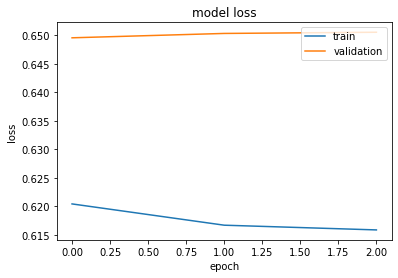

In [239]:
plot_history(history)

In [240]:
movie_layer_2 = collab_nn_2.get_layer('movie-embedding')
movie_weights_2 = movie_layer_2.get_weights()[0]
movie_weights_2.shape

(59048, 100)

In [241]:
movie_weights_2 = pd.DataFrame(movie_weights_2)
movie_weights_2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.050,0.037,-0.005,0.008,0.025,-0.072,-0.029,0.008,-0.227,-0.138,...,-0.066,-0.060,0.068,-0.002,-0.044,-0.004,-0.036,-0.013,-0.062,-0.094
1,0.015,-0.020,0.058,-0.014,0.043,0.023,-0.099,-0.052,0.212,-0.085,...,0.024,-0.087,-0.109,-0.016,0.299,0.028,-0.000,0.027,0.018,-0.012
2,0.068,0.152,0.256,0.082,0.049,0.083,-0.021,0.026,0.337,0.014,...,-0.080,-0.004,-0.064,0.087,0.295,-0.017,-0.037,0.138,-0.032,0.075
3,-0.046,0.074,0.123,0.057,0.036,-0.054,-0.042,0.010,0.213,-0.035,...,-0.053,0.072,-0.043,-0.028,0.327,-0.116,-0.007,-0.002,-0.034,-0.034
4,0.022,0.039,0.037,0.023,-0.036,-0.091,-0.075,0.164,0.149,0.058,...,-0.094,-0.077,-0.048,-0.059,0.195,-0.071,0.079,-0.010,0.031,0.064


In [242]:
save_collab_nn_embeddings(24, movie_weights_2)

In [243]:
get_detailed_recs(245, movie_weights_2)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
245,245.000,Batman Begins (2005),Action Crime IMAX,action batman billionaire Christian Bale comic...,Action Crime IMAX action batman billionaire Ch...,3.930,30684,1.000
578,578.000,"Dark Knight, The (2008)",Action Crime Drama IMAX,action Atmospheric Batman Christian Bale comic...,Action Crime Drama IMAX action Atmospheric Bat...,4.167,41519,0.845
698,698.000,"Dark Knight Rises, The (2012)",Action Adventure Crime IMAX,superhero Anne Hathaway Christian Bale Christo...,Action Adventure Crime IMAX superhero Anne Hat...,3.971,19912,0.800
30119,30119.000,Detective Conan: The Last Wizard of the Centur...,Animation Thriller,anime fugitive treasure Anime Assassin Detecti...,Animation Thriller anime fugitive treasure Ani...,4.033,15,0.793
41791,41791.000,Love is God (2003),Adventure Comedy Drama,altruism atheism communism disabled humanitari...,Adventure Comedy Drama altruism atheism commun...,3.833,15,0.777
34125,34125.000,Fonzy (2013),Comedy,woman director,Comedy woman director,4.333,3,0.775
31900,31900.000,The Rise and Rise of Bitcoin (2014),Documentary,money technology,Documentary money technology,3.607,14,0.774
41711,41711.000,100% Love (2011),Drama Romance,ego genius love romance,Drama Romance ego genius love romance,3.643,7,0.771
7098,7098.000,Active Measures (2018),Documentary,,Documentary,3.611,18,0.770
21654,21654.000,Flavors of Youth (2018),Animation Drama Romance,disconnected friendship nostalgia past and pre...,Animation Drama Romance disconnected friendshi...,3.304,23,0.766


In [244]:
get_detailed_recs(36, movie_weights_2)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
36,36.000,"Lord of the Rings: The Two Towers, The (2002)",Adventure Fantasy,morality Owned imdb top 250 Adventure based on...,Adventure Fantasy morality Owned imdb top 250 ...,4.068,51138,1.000
202,202.000,"Lord of the Rings: The Fellowship of the Ring,...",Adventure Fantasy,tolkien Adventure high fantasy music tolkien w...,Adventure Fantasy tolkien Adventure high fanta...,4.091,55736,0.939
227,227.000,"Lord of the Rings: The Return of the King, The...",Action Adventure Drama Fantasy,Owned imdb top 250 Adventure epic adventure hi...,Action Adventure Drama Fantasy Owned imdb top ...,4.090,50797,0.933
17049,17049.000,The Snatch Thief (2018),Drama,argentinian movie redemption,Drama argentinian movie redemption,4.000,3,0.832
34125,34125.000,Fonzy (2013),Comedy,woman director,Comedy woman director,4.333,3,0.766
31900,31900.000,The Rise and Rise of Bitcoin (2014),Documentary,money technology,Documentary money technology,3.607,14,0.749
30119,30119.000,Detective Conan: The Last Wizard of the Centur...,Animation Thriller,anime fugitive treasure Anime Assassin Detecti...,Animation Thriller anime fugitive treasure Ani...,4.033,15,0.749
30800,30800.000,Forbidden Photos of a Lady Above Suspicion (1970),Mystery,blackmail lesbian lesbian sex madrid photograp...,Mystery blackmail lesbian lesbian sex madrid p...,3.438,8,0.745
41791,41791.000,Love is God (2003),Adventure Comedy Drama,altruism atheism communism disabled humanitari...,Adventure Comedy Drama altruism atheism commun...,3.833,15,0.743
41711,41711.000,100% Love (2011),Drama Romance,ego genius love romance,Drama Romance ego genius love romance,3.643,7,0.738


In [245]:
get_detailed_recs(159, movie_weights_2)

,movieId,title,genres,tag,corpus,rating,ratings_count,similarity_score
159,159.000,"Matrix, The (1999)",Action SciFi Thriller,alternate reality artificial intelligence cybe...,Action SciFi Thriller alternate reality artifi...,4.154,72674,1.000
21303,21303.000,Paris Can Wait (2017),Romance,france husband life love paris travel woman di...,Romance france husband life love paris travel ...,3.146,24,0.814
28108,28108.000,José and Pilar (José e Pilar) (2010),Documentary,Miguel Gonçalves Mendes,Documentary Miguel Gonçalves Mendes,4.083,6,0.811
30119,30119.000,Detective Conan: The Last Wizard of the Centur...,Animation Thriller,anime fugitive treasure Anime Assassin Detecti...,Animation Thriller anime fugitive treasure Ani...,4.033,15,0.807
34125,34125.000,Fonzy (2013),Comedy,woman director,Comedy woman director,4.333,3,0.803
14261,14261.000,The Bachelors (2017),Comedy Drama,fresh start parent child relationship romance ...,Comedy Drama fresh start parent child relation...,3.344,16,0.798
50695,50695.000,Shwaas (2004),Drama,drama emotional grandfather-grandson relations...,Drama drama emotional grandfather-grandson rel...,4.250,2,0.796
6461,6461.000,Battle of the Warriors (2006),Action Drama War,china life philosophy mozi philosophy personal...,Action Drama War china life philosophy mozi ph...,3.625,4,0.796
36764,36764.000,The Fort (2014),Comedy Drama,beautiful imagery coming of age marathi mother...,Comedy Drama beautiful imagery coming of age m...,4.000,6,0.796
21025,21025.000,Okko's Inn (2018),Animation,ghosts,Animation ghosts,3.800,5,0.795


In [246]:
get_ensemble_recs(245, autoencoder_embedding, movie_weights_2)

,movieId,title,genres,tag,corpus,rating,ratings_count,collaborative_similarity_score,content_similarity_score,average_similarity_score
245,245.000,Batman Begins (2005),Action Crime IMAX,action batman billionaire Christian Bale comic...,Action Crime IMAX action batman billionaire Ch...,3.930,30684,1.000,1.000,1.000
578,578.000,"Dark Knight, The (2008)",Action Crime Drama IMAX,action Atmospheric Batman Christian Bale comic...,Action Crime Drama IMAX action Atmospheric Bat...,4.167,41519,0.845,0.816,0.830
698,698.000,"Dark Knight Rises, The (2012)",Action Adventure Crime IMAX,superhero Anne Hathaway Christian Bale Christo...,Action Adventure Crime IMAX superhero Anne Hat...,3.971,19912,0.800,0.802,0.801
19550,19550.000,The Death of Superman,Action Animation Drama SciFi,Adult animation Batman Superhero Batman Superhero,Action Animation Drama SciFi Adult animation B...,3.365,52,0.740,0.686,0.713
967,967.000,Batman (1989),Action Crime Thriller,DC Comics superhero dark hero atmospheric blea...,Action Crime Thriller DC Comics superhero dark...,3.407,44110,0.405,0.919,0.662
206,206.000,Spider-Man (2002),Action Adventure SciFi Thriller,Special effects marvel superhero superheroes c...,Action Adventure SciFi Thriller Special effect...,3.479,30010,0.457,0.848,0.652
233,233.000,Spider-Man 2 (2004),Action Adventure SciFi IMAX,Marvel superhero marvel comic book based on co...,Action Adventure SciFi IMAX Marvel superhero m...,3.445,20725,0.419,0.861,0.640
442,442.000,Big Fish (2003),Drama Fantasy Romance,dreamlike Fantasy imagination surreal surreali...,Drama Fantasy Romance dreamlike Fantasy imagin...,3.799,17528,0.541,0.722,0.631
579,579.000,Iron Man (2008),Action Adventure SciFi,Marvel own superhero afghanistan android(s)/cy...,Action Adventure SciFi Marvel own superhero af...,3.834,25671,0.717,0.515,0.616
830,830.000,Logan (2017),Action SciFi,dark dark hero R rated dark dark hero gritty H...,Action SciFi dark dark hero R rated dark dark ...,3.895,6739,0.579,0.637,0.608


In [247]:
get_ensemble_recs(36, autoencoder_embedding, movie_weights_2)

,movieId,title,genres,tag,corpus,rating,ratings_count,collaborative_similarity_score,content_similarity_score,average_similarity_score
36,36.000,"Lord of the Rings: The Two Towers, The (2002)",Adventure Fantasy,morality Owned imdb top 250 Adventure based on...,Adventure Fantasy morality Owned imdb top 250 ...,4.068,51138,1.000,1.000,1.000
202,202.000,"Lord of the Rings: The Fellowship of the Ring,...",Adventure Fantasy,tolkien Adventure high fantasy music tolkien w...,Adventure Fantasy tolkien Adventure high fanta...,4.091,55736,0.939,0.995,0.967
227,227.000,"Lord of the Rings: The Return of the King, The...",Action Adventure Drama Fantasy,Owned imdb top 250 Adventure epic adventure hi...,Action Adventure Drama Fantasy Owned imdb top ...,4.090,50797,0.933,0.979,0.956
102,102.000,Star Wars: Episode V - The Empire Strikes Back...,Action Adventure SciFi,80s old movie imdb top 250 George Lucas great ...,Action Adventure SciFi 80s old movie imdb top ...,4.144,57361,0.686,0.971,0.828
76,76.000,Star Wars: Episode IV - A New Hope (1977),Action Adventure SciFi,classic sci-fi action adventure fantasy space ...,Action Adventure SciFi classic sci-fi action a...,4.120,68717,0.676,0.967,0.822
106,106.000,Star Wars: Episode VI - Return of the Jedi (1983),Action Adventure SciFi,bah adventure Harrison Ford Star wars old movi...,Action Adventure SciFi bah adventure Harrison ...,3.997,54917,0.672,0.970,0.821
159,159.000,"Matrix, The (1999)",Action SciFi Thriller,alternate reality artificial intelligence cybe...,Action SciFi Thriller alternate reality artifi...,4.154,72674,0.665,0.959,0.812
654,654.000,Inception (2010),Action Crime Drama Mystery SciFi Thriller IMAX,sci-fi action alternate reality drama psycholo...,Action Crime Drama Mystery SciFi Thriller IMAX...,4.156,38895,0.623,0.958,0.790
586,586.000,WALL·E (2008),Adventure Animation Children Romance SciFi,tear jerker Owned boring dystopia adventure. r...,Adventure Animation Children Romance SciFi tea...,4.005,27374,0.616,0.947,0.781
40,40.000,Pirates of the Caribbean: The Curse of the Bla...,Action Adventure Comedy Fantasy,imdb top 250 treasure treasure adventure comed...,Action Adventure Comedy Fantasy imdb top 250 t...,3.789,37227,0.586,0.947,0.767


In [248]:
get_ensemble_recs(159, autoencoder_embedding, movie_weights_2)

,movieId,title,genres,tag,corpus,rating,ratings_count,collaborative_similarity_score,content_similarity_score,average_similarity_score
159,159.000,"Matrix, The (1999)",Action SciFi Thriller,alternate reality artificial intelligence cybe...,Action SciFi Thriller alternate reality artifi...,4.154,72674,1.000,1.000,1.000
654,654.000,Inception (2010),Action Crime Drama Mystery SciFi Thriller IMAX,sci-fi action alternate reality drama psycholo...,Action Crime Drama Mystery SciFi Thriller IMAX...,4.156,38895,0.763,0.957,0.860
586,586.000,WALL·E (2008),Adventure Animation Children Romance SciFi,tear jerker Owned boring dystopia adventure. r...,Adventure Animation Children Romance SciFi tea...,4.005,27374,0.685,0.993,0.839
102,102.000,Star Wars: Episode V - The Empire Strikes Back...,Action Adventure SciFi,80s old movie imdb top 250 George Lucas great ...,Action Adventure SciFi 80s old movie imdb top ...,4.144,57361,0.694,0.984,0.839
516,516.000,V for Vendetta (2006),Action SciFi Thriller IMAX,dark dystopia philosophy thought-provoking imd...,Action SciFi Thriller IMAX dark dystopia philo...,3.908,25990,0.682,0.994,0.838
251,251.000,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery SciFi Thriller,imdb top 250 asylum biological warfare dystopi...,Mystery SciFi Thriller imdb top 250 asylum bio...,3.906,47054,0.677,0.989,0.833
252,252.000,"Usual Suspects, The (1995)",Crime Mystery Thriller,imdb top 250 heist suspense thriller twist end...,Crime Mystery Thriller imdb top 250 heist susp...,4.284,55366,0.710,0.955,0.833
225,225.000,Hero (Ying xiong) (2002),Action Adventure Drama,imdb top 250 amazing photography amazing photo...,Action Adventure Drama imdb top 250 amazing ph...,3.897,8236,0.689,0.968,0.829
126,126.000,"Fifth Element, The (1997)",Action Adventure Comedy SciFi,Bruce Willis Milla Jovovich parody sci-fi visu...,Action Adventure Comedy SciFi Bruce Willis Mil...,3.770,33153,0.661,0.994,0.827
1686,1686.000,Moon (2009),Drama Mystery SciFi Thriller,artificial intelligence death dialogue driven ...,Drama Mystery SciFi Thriller artificial intell...,4.018,11027,0.657,0.993,0.825
